In [1]:
import DiFfRG.phasediagram as pd
import DiFfRG.file_io as io
import DiFfRG.plot as plt
import numpy as np
import glob
import os

In [2]:
def load_data():
  global sims, csvs, params
  sims = glob.glob('./PhaseDiagram/*.log')
  sims = [sim[:-4].split('/')[-1] for sim in sims]
  csvs = [f'./PhaseDiagram/{sim}_data.csv' for sim in sims]
  params = [io.get_parameters_from_name(sim) for sim in sims]
  
def clear_data():
  load_data()
  for i, csv in enumerate(csvs):
    if not os.path.exists(csv):
      baseName = './PhaseDiagram/' + sims[i]
      print('removing', baseName)
      os.system(f'rm -r {baseName}/ {baseName}.log {baseName}.log.json')
  load_data()
  
def tell_learner(learner):
  clear_data()
  for i, csv in enumerate(csvs):
    lambda1 = io.read_csv(csv)["lambda1"].to_numpy()[-1]
    prm = params[i]
    print(i, " ", csv, " : ", lambda1, " ", prm)
    learner.tell((prm['muq'], prm['T']), lambda1)
  
def get_data():
  load_data()
  global in_data
  in_data = {}
  T = []
  muq = []
  lambdas = []
  for i, csv in enumerate(csvs):
    # check if file exists
    if not os.path.exists(csv):
      continue
    csv_data = io.read_csv(csv)

    if csv_data['t'].to_numpy()[-1] < 3.8:
      continue

    prm = params[i]
    T.append(prm['T'])
    muq.append(prm['muq'])

    mlambdas = []
    # do the above faster with a for loop:
    for i in range(1, 11):
      mlambdas.append(csv_data[f'lambda{i}'].to_numpy()[-1])
    mlambdas.append(csv_data['lambda_csc'].to_numpy()[-1])

    for i in range(len(mlambdas)):
      if len(lambdas) <= i:
        lambdas.append([])
      lambdas[i].append(mlambdas[i])

  in_data['T'] = np.array(T)
  in_data['muq'] = np.array(muq)
  in_data['lambdas'] = np.array(lambdas)

In [ ]:
import adaptive
adaptive.notebook_extension()
from concurrent.futures import ProcessPoolExecutor

folder = "./PhaseDiagram/"
parameter = "./parameter.json"
executable = "./build/FourFermi"
observable_to_learn = "lambda1"
loss_goal = 0.01

specification = [
    {"parameter": "/physical/muq", "bounds": [0.0, 0.4]},
    {"parameter": "/physical/T", "bounds": [0.0, 0.2]},
]

def solve_point(point):
    pd_point = [[spec["parameter"], point[i]] for i, spec in enumerate(specification)]
    name = pd.run_point(executable, pd_point, folder=folder, add_params=f"")
    csv = folder + name + "_data.csv" 
    ob = io.read_csv(csv)[observable_to_learn].to_numpy()[-1]
    return ob

bounds = []
for spec in specification:
    bounds.append(spec["bounds"])

learner = adaptive.LearnerND(solve_point, bounds=bounds)
tell_learner(learner)

executor = ProcessPoolExecutor(max_workers=4)
runner = adaptive.Runner(
    learner,
    executor=executor,
    loss_goal=loss_goal,
)
runner.live_info()  # shows a widget with status information
#runner.live_plot()

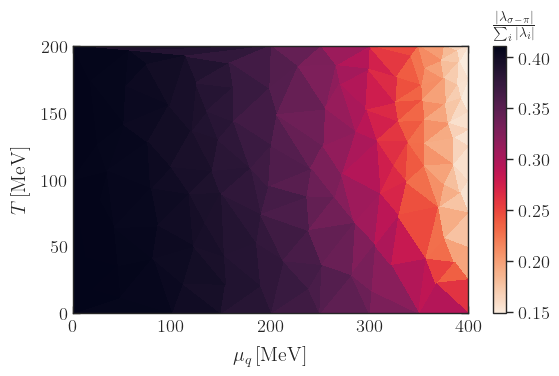

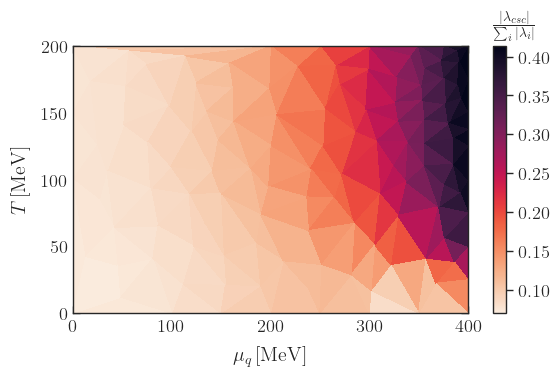

In [4]:
get_data()

sum_all = np.sum(in_data['lambdas'][:-2,:], axis=0)
csc = np.abs(in_data['lambdas'][-1, :] * 29 / sum_all)
sigpi  = np.abs(in_data['lambdas'][0, :] / sum_all)

plt.plot_2D(
    {
        "x" : in_data['muq'] * 1e3,
        "y" : in_data['T'] * 1e3,
        "z" : sigpi,
    },
    cmap="rocket_r",
    #style="3D",
    levels=100,
    #grid=True,
    xlabel=r"$\mu_q\,\textrm{[MeV]}$",
    ylabel=r"$T\,\textrm{[MeV]}$",
    zlabel=r"$\frac{|\lambda_{\sigma-\pi}|}{\sum_i|\lambda_i|}$",
    #xlim = (-200, -100),
    #ylim = (50, 230),
    #zlim = (0, 0.10),
    #angle_3d=(25, 45),
    #file="Four_fermi_sigpi.pdf"
)

import importlib
importlib.reload(plt)

plt.plot_2D(
    {
        "x" : in_data['muq'] * 1e3,
        "y" : in_data['T'] * 1e3,
        "z" : csc,
    },
    cmap="rocket_r",
    #style="3D",
    levels=100,
    #grid=True,
    xlabel=r"$\mu_q\,\textrm{[MeV]}$",
    ylabel=r"$T\,\textrm{[MeV]}$",
    zlabel=r"$\frac{|\lambda_{csc}|}{\sum_i|\lambda_i|}$\\",
    #xlim = (-200, -100),
    #ylim = (50, 230),
    #zlim = (0, 0.10),
    #angle_3d=(25, 45),
    #figsize=(7,4),
    #file="Four_fermi_csc.pdf"
)